## Probabilistic Learning on Manifolds (IDA of a 12-story RC frame)

In this example, raw data from Incremental Dynamic Analysis (IDA) of a 12-story RC frame are used as the input sample. Similar to the previous example (i.e., example1), the interested engineering demand parameters include maximum story drift ratio and peak floor acceleration. The intensity measures for quantifying the ground motion characeteristics include pseudo spectral acceleration $Sa(T_1)$, response spectral shape measture $SaRatio$, and 5-75% significant duration $D_{S5-75}$.

The IDA ground motions include 49 records with various $SaRati$ and $D_{S5-75}$, and the entire sample data include 478 points. The goal is (1) to use PLoM learn the data structure and generate more samples whose key statistics (i.e., mean and covariance) are consistent with the input samplem, and (2) to resample the PLoM-estimated EDPs given specific site hazard (i.e., a specific joint distribution of $Sa$, $SaRatio$, and $D_{S5-75}$).

### Import python modules

In [15]:
import numpy as np
import random
import time
from math import pi
import pandas as pd
from ctypes import *
%matplotlib notebook
import matplotlib.pyplot as plt

### Import PLoM modules

In [16]:
import os
cwd = os.getcwd()
os.chdir('../../')
import PLoM_library_ubuntu as plom
os.chdir(cwd)

In [17]:
t_start = time.time()

### Load Multi-Stripe Analysis (MSA) Data
MSA data are loaded via a comma-separate value (csv) file. The first row contains column names for both predictors (X) and responses (y). The following rows are input sample data. Users are expected to specif the csv filename.

<IPython.core.display.Javascript object>


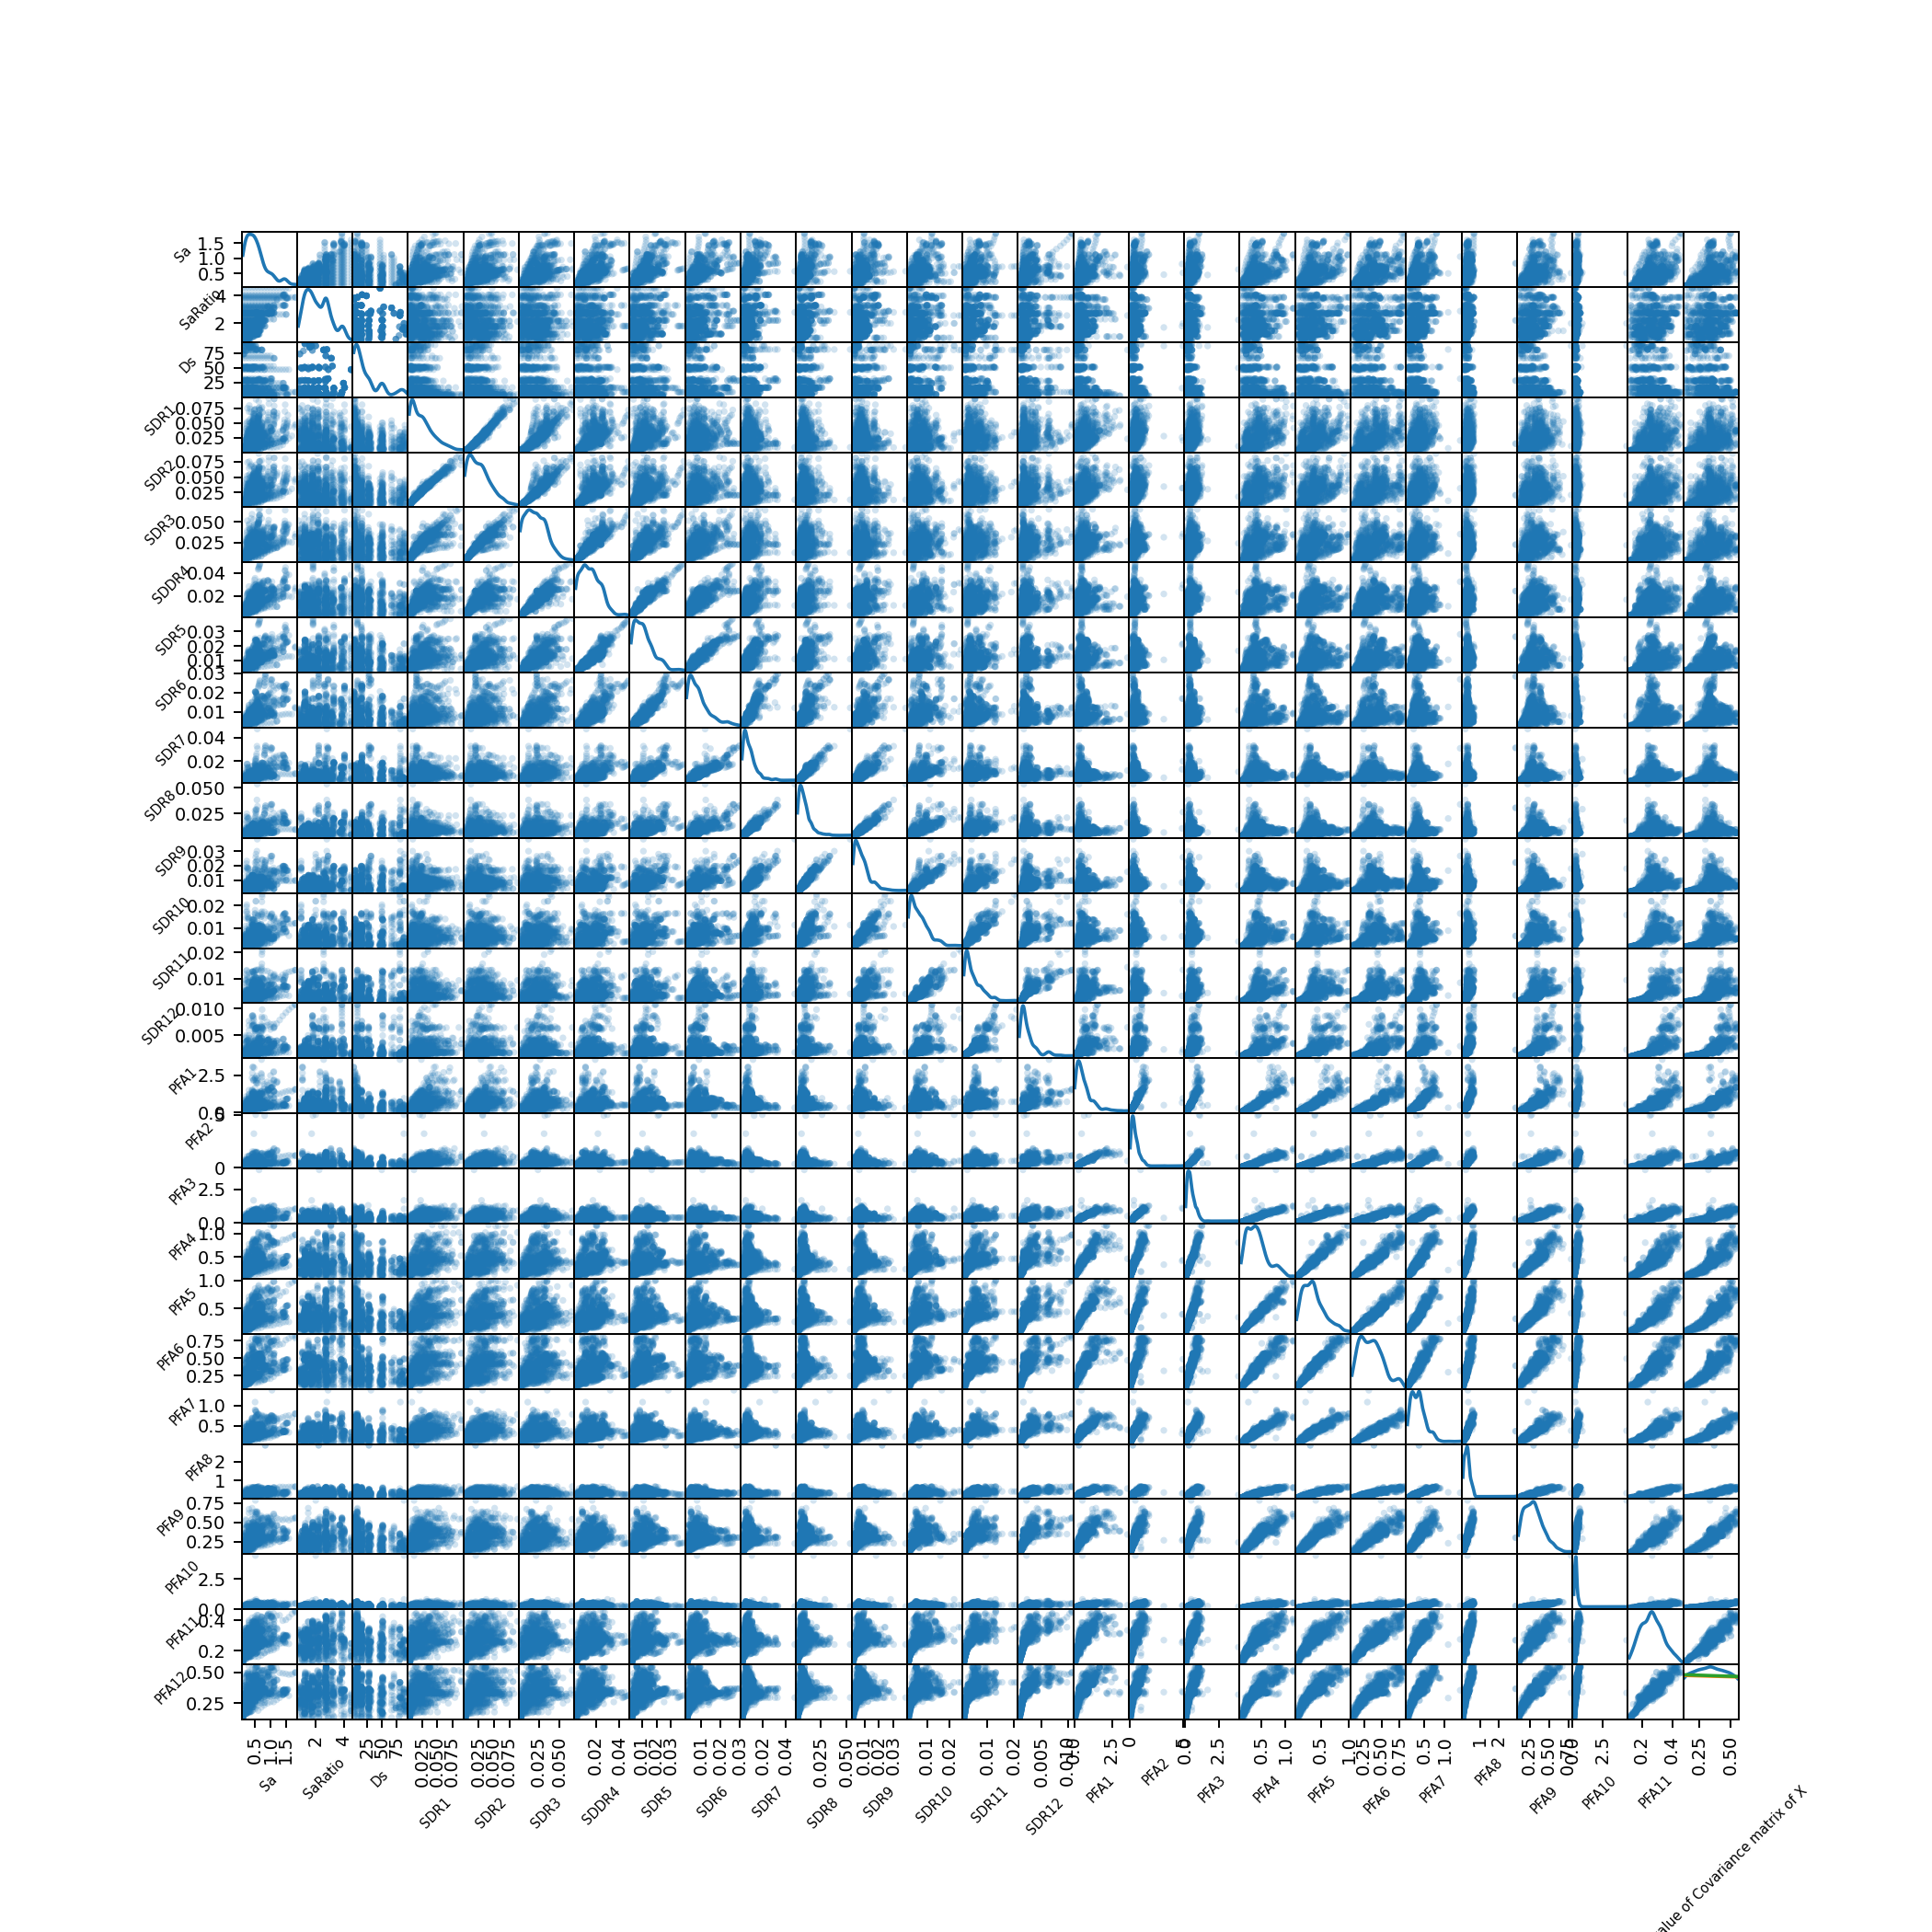

In [18]:
# Filename
filename = './data/response_frame12_ida_comb.csv'
df = pd.read_csv(filename, header=0, index_col=None)

# Initialize x
N = len(df.index)
n = len(df.columns)
x0 = np.zeros((n, N))
x_name = []

# Read data
for i in range(n):
    x0[i] = [np.log(x) for x in df.iloc[:, i].values.tolist()]
    x_name.append(df.columns[i])
    
# Plot scatter matrix of the sample
smp = pd.plotting.scatter_matrix(df, alpha=0.2, diagonal = "kde", figsize=(12, 12))
for ax in smp.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize = 6, rotation = 45)
    ax.set_ylabel(ax.get_ylabel(), fontsize = 6, rotation = 45)

### User Specified Parameter
Please specify tuning parameters in this section

In [19]:
epsilon_pca = 1e-6 # tolerance for selecting the number of considered components
epsilon_kde = 25 # smoothing parameter in the kernel density
n_mc = 20 # realization/sample size ratio

### Step 0: Scaling the data

In [20]:
def g_c(x): #x can be a column vector or a matrix
    f = np.zeros((2, x.shape[1]))
    f[0,:] = x[0,:]
    f[1,:] = x[0,:]**2
    return f

x, alpha, x_min = plom.scaling(x0)

x_mean = plom.mean(x)

N = x.shape[1] #initial number of points
n = x.shape[0] #initial dimension

### Step 1: Principal Component Analysis (PCA)

Considered number of components:  27


<IPython.core.display.Javascript object>


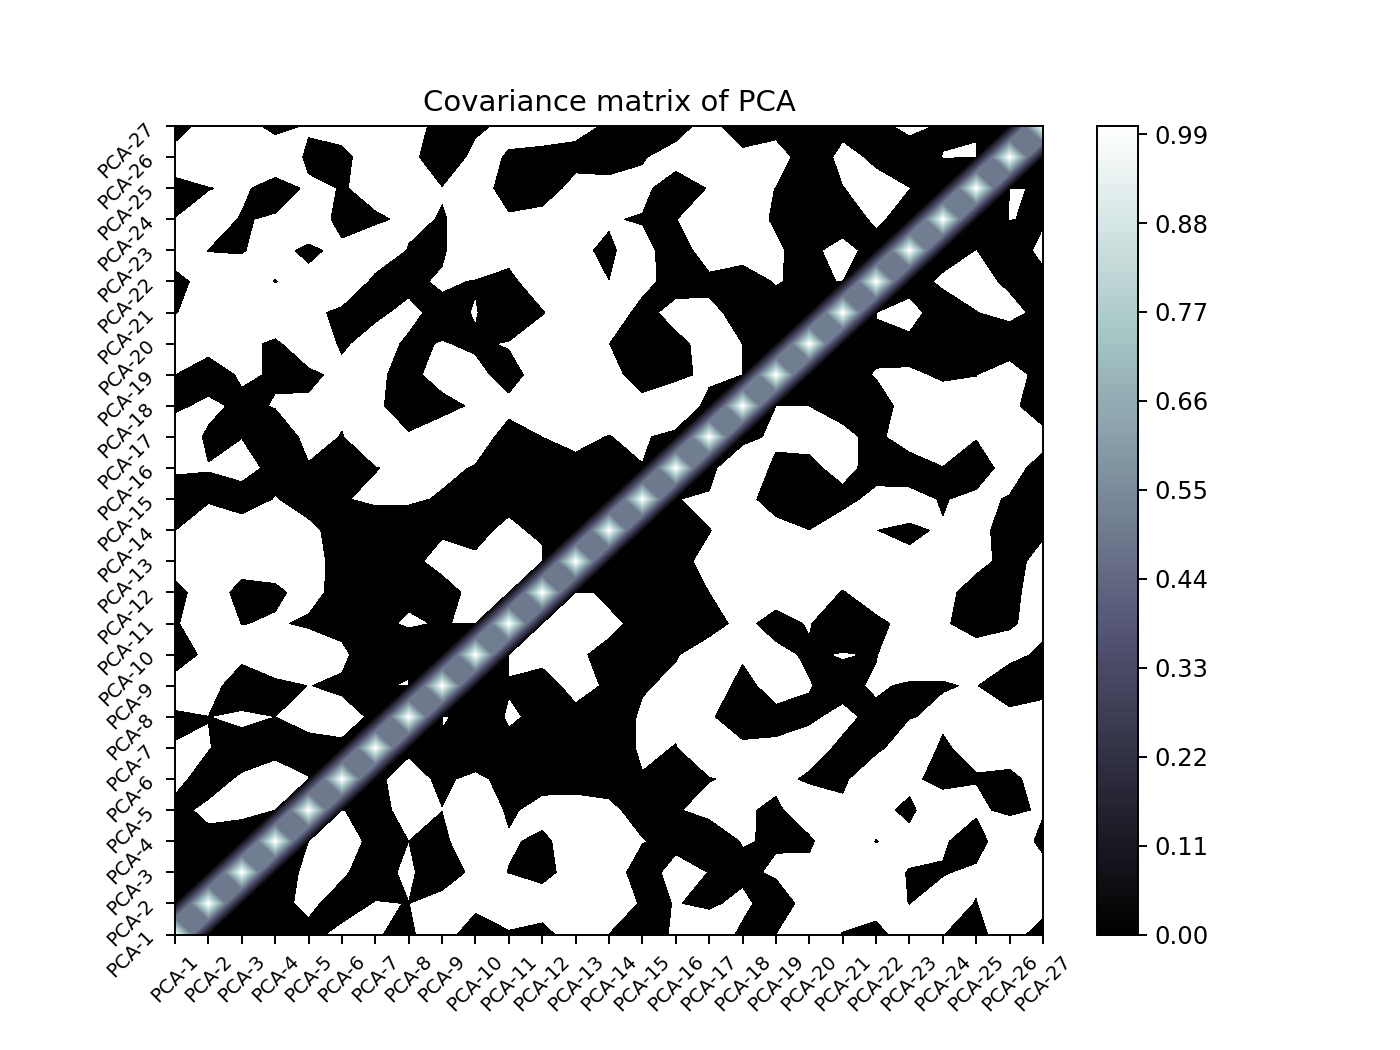

In [21]:
(eta, mu, phi) = plom.PCA(x, epsilon_pca)
nu = len(eta)
print('Considered number of components: ', nu)

plom.covariance(eta)

# Plot covariance matrix
fig, ax = plt.subplots(figsize=(8,6))
ctp = ax.contourf(plom.covariance(eta), cmap=plt.cm.bone, levels=100)
ax.set_xticks(list(range(n)))
ax.set_yticks(list(range(n)))
ax.set_xticklabels(['PCA-'+str(x+1) for x in range(n)], fontsize=8, rotation=45)
ax.set_yticklabels(['PCA-'+str(x+1) for x in range(n)], fontsize=8, rotation=45)
ax.set_title('Covariance matrix of PCA')
cbar = fig.colorbar(ctp)
plt.show()

### Step 2: Kernel Density Estimation (KDE)

m:  36


<IPython.core.display.Javascript object>


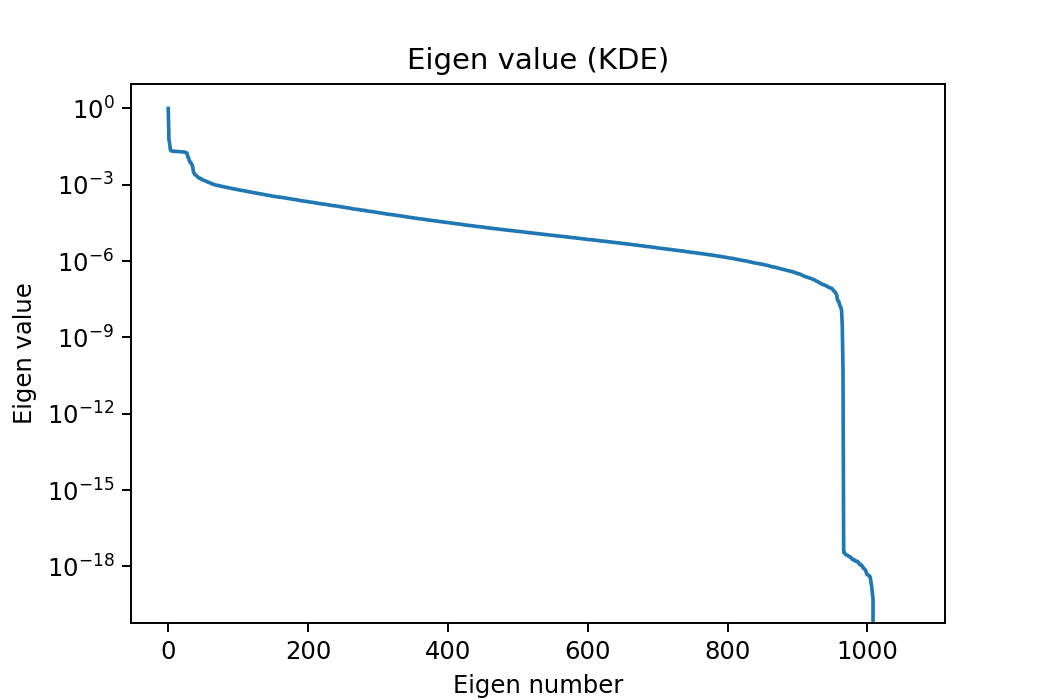

In [22]:
(s_v, c_v, hat_s_v) = plom.parameters_kde(eta)

K, b = plom.K(eta,epsilon_kde)

g, eigenvalues = plom.g(K,b) #diffusion maps
g = g.real
eigenvalues = eigenvalues.real
m = plom.m(eigenvalues)
print('m: ', m)
a = g[:,0:m].dot(np.linalg.inv(np.transpose(g[:,0:m]).dot(g[:,0:m])))

# Plot
fig, ax = plt.subplots(figsize=(6,4))
ax.semilogy(np.arange(len(eigenvalues)), eigenvalues)
ax.set_xlabel('Eigen number')
ax.set_ylabel('Eigen value')
ax.set_title('Eigen value (KDE)')
plt.show()

### Step 3: Create the generator

delta t:  0.18844382365263854


<IPython.core.display.Javascript object>


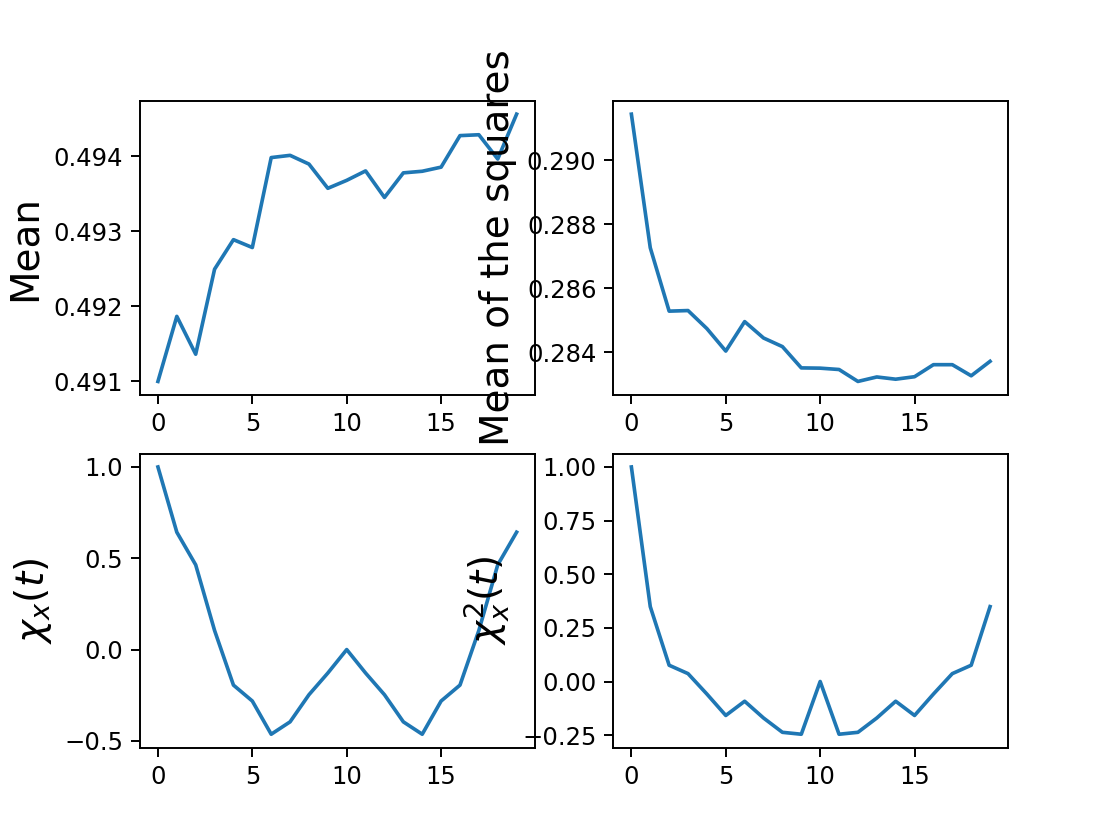

In [23]:
eta_init = eta #use the sample as the initial vector
nu_init = np.random.normal(size = (nu,N))


z_init = eta_init.dot(a)
y_init = nu_init.dot(a)

# Create the generator
eta_lambda, nu_lambda, x_, x_2 = plom.generator(z_init, y_init, a,\
                        n_mc, x_mean, eta, s_v, hat_s_v, mu, phi, g[:,0:m]) #solve the ISDE in n_mc iterations

plt.figure()
plt.subplot(2,2,1)
plt.plot(x_[0,:])
plt.ylabel('Mean',fontsize=16)

plt.subplot(2,2,2)
plt.plot(x_2[0,:])
plt.ylabel('Mean of the squares',fontsize=16)

plt.subplot(2,2,3)
chi = plom.ac(x_[0,:(n_mc//2)])
plt.plot(chi[:chi.size]/chi[0])
plt.ylabel(r'$\chi_x(t)$',fontsize=16)

plt.subplot(2,2,4)
chi = plom.ac(x_2[0,:(n_mc//2)])
plt.plot(chi[:chi.size]/chi[0])
plt.ylabel(r'$\chi_x^{2}(t)$',fontsize=16)
plt.show()
plt.savefig('realization.png')



### Step 4: New realizations (MCMC)

In [24]:
# Transform \eta back to X
x_c = x_mean + phi.dot(np.diag(mu)).dot(eta_lambda)

# Unscale X
x_c = np.diag(alpha).dot(x_c)+x_min
x = np.diag(alpha).dot(x)+x_min

plom.mean(x_c[:,:])
x_c.shape

# Save data
np.savetxt('sample.csv', np.exp(x), delimiter=',')
np.savetxt('simulation.csv', np.exp(x_c), delimiter=',')

t_end = time.time()
print("Time: " + str(t_end - t_start) + ' sec.')

Time: 78.77095627784729 sec.


### Post-processing
We would like to check the basic statistics of the input sample (i.e., MSA) and the generated new realizations by PLoM. The key metrics include the median, standard deviation, and correlation coefficient matrix of different structural responses.

<IPython.core.display.Javascript object>


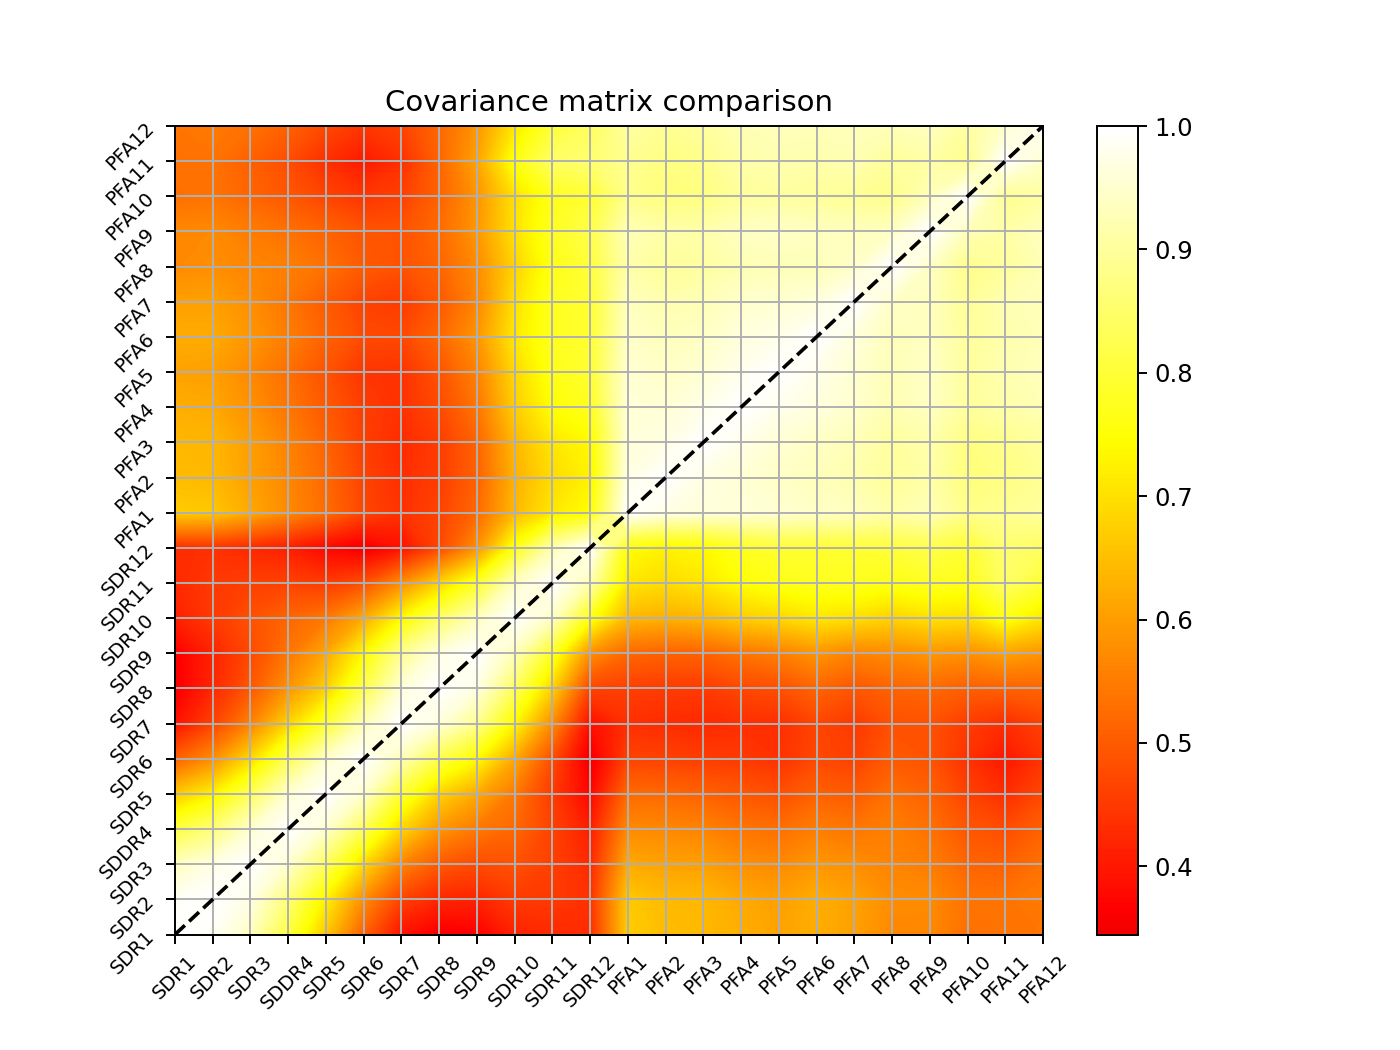

<IPython.core.display.Javascript object>


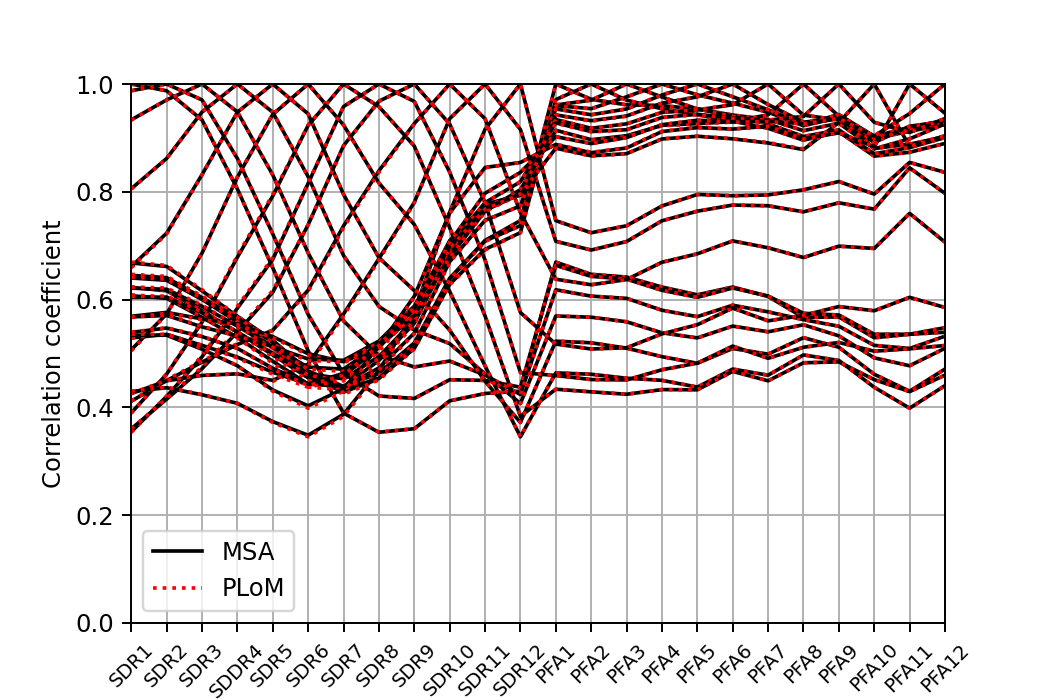

In [25]:
# Correlation coefficient matrix
c_msa = np.corrcoef(x0)
c_plom = np.corrcoef(x_c)
c_combine = c_msa
tmp = np.triu(c_plom).flatten()
tmp = tmp[tmp != 0]
c_combine[np.triu_indices(27)] = tmp

# Plot covariance matrix
fig, ax = plt.subplots(figsize=(8,6))
ctp = ax.contourf(c_combine[3:,3:], cmap=plt.cm.hot, levels=1000)
ctp.set_clim(0,1)
ax.plot([0, 23], [0, 23], 'k--')
ax.set_xticks(list(range(n-3)))
ax.set_yticks(list(range(n-3)))
ax.set_xticklabels(x_name[3:], fontsize=8, rotation=45)
ax.set_yticklabels(x_name[3:], fontsize=8, rotation=45)
ax.set_title('Covariance matrix comparison')
ax.grid()
cbar = fig.colorbar(ctp,ticks=[x/10 for x in range(11)])
plt.show()

# Plot the cross-section of correlation matrix
fig, ax = plt.subplots(figsize=(6,4))
ax.plot([0],[0],'k-',label='MSA')
ax.plot([0],[0],'r:',label='PLoM')
for i in range(n-3):
    ax.plot(np.array(range(n-3)),c_msa[i+3][3:],'k-')
    ax.plot(np.array(range(n-3)),c_plom[i+3][3:],'r:')
ax.set_xticks(list(range(n-3)))
ax.set_xticklabels(x_name[3:], fontsize=8, rotation=45)
ax.set_ylabel('Correlation coefficient')
ax.set_ylim([0,1])
ax.set_xlim([0,n-4])
ax.legend()
ax.grid()
plt.show()

### Hazard Adjustment
This section can be used to process the PLoM predictions from raw IDA training. Site specific hazard information is needed as an input. An example site hazard csv file is provided, the first column is the Sa intensity, the second column is the median SaRatio, the third column is the median duration, and the last four columns are covariance matrix entries.

In [32]:
# Load site hazard information
shz = pd.read_csv('./data/site_hazard.csv')
print(shz)
print(np.array(shz.iloc[0]['cov11':]).reshape((2,2)))

       Sa  mSaRatio       mDs     cov11     cov12     cov21   cov22
0  0.1690  0.494493  2.187499  0.073322 -0.011835 -0.011835  0.2306
1  0.2594  0.533634  2.150060  0.073322 -0.011835 -0.011835  0.2306
2  0.3696  0.586958  2.116164  0.073322 -0.011835 -0.011835  0.2306
3  0.5492  0.696371  2.124474  0.073322 -0.011835 -0.011835  0.2306
4  0.7131  0.815519  2.134961  0.073322 -0.011835 -0.011835  0.2306
5  0.9000  0.917086  2.228618  0.073322 -0.011835 -0.011835  0.2306
[[ 0.07332215 -0.01183476]
 [-0.01183476  0.2306    ]]


In [63]:
# Draw samples from the site distribution
num_rlz = 1000 # sample size
np.random.seed(1) # random seed for replicating results
rlz_imv = []
for i in range(len(shz.index)):
    rlz_imv.append(np.random.multivariate_normal(mean=[shz['mSaRatio'][i],shz['mDs'][i]],cov=np.array(shz.iloc[i]['cov11':]).reshape((2,2)),size=num_rlz))

<IPython.core.display.Javascript object>


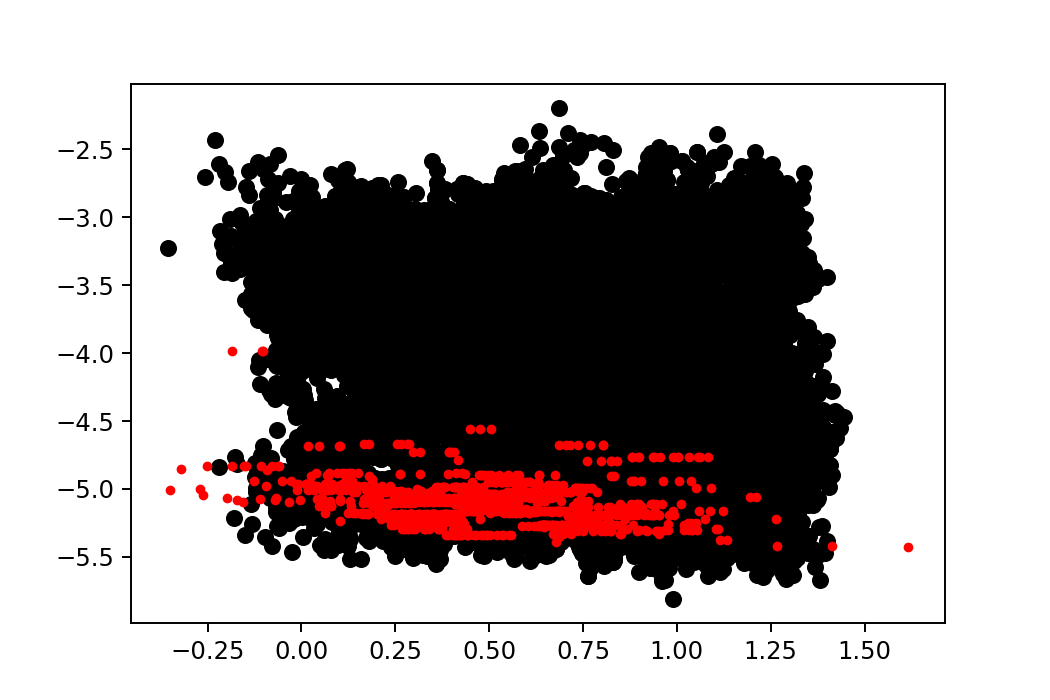

<IPython.core.display.Javascript object>


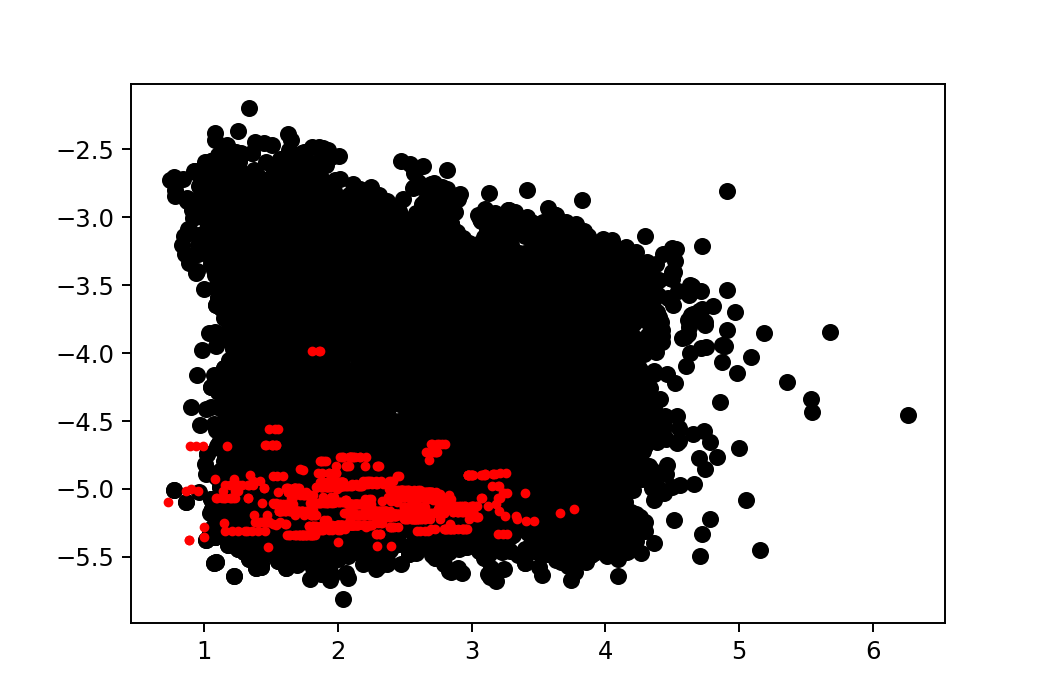

In [66]:
# Search nearest PLoM data points for each sample in rlz_imv
num_nn = 5 # number of nearest neighbors
lnsa_plom = x_c[0]
lnsaratio_plom = x_c[1]
lnds_plom = x_c[2]

# Create the nearest interporator
from scipy.interpolate import NearestNDInterpolator
interp_nn = NearestNDInterpolator(list(zip(lnsa_plom,lnsaratio_plom,lnds_plom)),x_c[3])
# Interporating the data
pred_nn = interp_nn(np.ones(rlz_imv[0][:,0].shape)*np.log(shz['Sa'][0]),rlz_imv[0][:,0],rlz_imv[0][:,1])

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(lnsaratio_plom,x_c[3],'ko',label='PLoM')
ax.plot(rlz_imv[0][:,0],pred_nn,'r.',label='Resample')
plt.show()

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(lnds_plom,x_c[3],'ko',label='PLoM')
ax.plot(rlz_imv[0][:,1],pred_nn,'r.',label='Resample')
plt.show()

In [74]:
ref_msa = pd.read_csv('./data/response_rcf12_msa_la_nc.csv')
print(ref_msa)
ref_sdr1_sa1 = ref_msa.loc[ref_msa['Sa']==0.169]['SDR1']
print(ref_sdr1_sa1)
print(np.exp(np.mean(np.log(ref_sdr1_sa1))))
print(np.std(np.log(ref_sdr1_sa1)))
print(np.exp(np.mean(pred_nn)))
print(np.std(pred_nn))

        Sa   SaRatio      Ds      SDR1      SDR2      SDR3     SDDR4  \
0    0.169  1.171803   9.345  0.004853  0.005062  0.003710  0.003204   
1    0.169  1.003348  12.748  0.005772  0.007791  0.007317  0.006695   
2    0.169  1.400105   8.620  0.006100  0.008452  0.007983  0.006856   
3    0.169  1.374257   5.265  0.010900  0.013080  0.011397  0.008093   
4    0.169  1.898769   8.610  0.004887  0.006293  0.005690  0.004231   
..     ...       ...     ...       ...       ...       ...       ...   
470  0.900  2.367299  19.620  0.026500  0.033000  0.035800  0.037200   
471  0.900  3.068148   6.760  0.019700  0.023600  0.022100  0.017500   
472  0.900  3.459921   8.020  0.023400  0.027600  0.026400  0.022700   
473  0.900  2.580551   2.130  0.028936  0.030451  0.026794  0.026925   
474  0.900  1.931883  10.985  0.023300  0.029600  0.031800  0.029800   

         SDR5      SDR6      SDR7  ...      PFA3      PFA4      PFA5  \
0    0.003223  0.003690  0.006587  ...  0.218142  0.209282  0.2

<ipython-input-74-979f83031554>:7: RuntimeWarning: invalid value encountered in log
  print(np.exp(np.mean(np.log(pred_nn))))
<ipython-input-74-979f83031554>:8: RuntimeWarning: invalid value encountered in log
  print(np.std(np.log(pred_nn)))


In [ ]:

for i in range(len(shz.index)):
    for i in range(num_rlz):
        err = (np.log(shz['Sa'][i])-lnsa_plom)**2+(rlz_imv[i][:,0]-lnsaratio_plom)**2+(rlz_imv[i][:,1]-lnds_plom)**2
        stag = np.argmin(err)
        # Use the nearest neighbors' mean to refer the PLoM